In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import time
import random
from datetime import datetime, timedelta
from shapely.geometry import Point
from busSim import BusSim

ModuleNotFoundError: No module named 'busSim'

In [ ]:
DATA_PATH = "./data"
DAY = "monday"
START_TIME = "12:00:00"
ELAPSE_TIME = "00:30:00"
AVG_WALKING_SPEED = 1.4  # 1.4 meters per second
MAX_WALKING_MIN = 10

In [3]:
def fmin(minutes):
    return f"{minutes // 60}:{minutes % 60}:00"

# doesn't account for time span across 2 days (not implement for across bus schedule: weekday -> weekend)
def every_time(interval, elapse_time):
    start_times = []
    curr = 0
    min_total = 24 * 60 - elapse_time
    while curr <= min_total:
        start_times.append(fmin(curr))
        curr += interval

    return start_times

In [4]:
start_times = every_time(10, 30)
perf = pd.DataFrame()

ts = time.time()
for t in start_times:
    print(t)
    # t0 = time.time()
    busSim = BusSim(DATA_PATH, DAY, t, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)
    t1 = time.time()
    gdf = busSim.get_gdf(start_point=(43.073691, -89.387407))
    t2 = time.time()
    busSim.get_area(gdf)
    t3 = time.time() 
    # perf.loc[t, "graph-gen"] = t1 - t0
    perf.loc[t, "graph-search"] = t2 - t1
    perf.loc[t, "calc-area"] = t3 - t2
    perf.loc[t, "total"] = t3 - t1
    perf.loc[t, "nodes-num"] = len(busSim.graph.nodes)

te = time.time()
perf

0:0:00
_transformer init
0:10:00
0:20:00
0:30:00
0:40:00
0:50:00
1:0:00
1:10:00
1:20:00
1:30:00
1:40:00
1:50:00
2:0:00
2:10:00
2:20:00
2:30:00
2:40:00
2:50:00
3:0:00
3:10:00
3:20:00
3:30:00
3:40:00
3:50:00
4:0:00
4:10:00
4:20:00
4:30:00
4:40:00
4:50:00
5:0:00
5:10:00
5:20:00
5:30:00
5:40:00
5:50:00
6:0:00
6:10:00
6:20:00
6:30:00
6:40:00
6:50:00
7:0:00
7:10:00
7:20:00
7:30:00
7:40:00
7:50:00
8:0:00
8:10:00
8:20:00
8:30:00
8:40:00
8:50:00
9:0:00
9:10:00
9:20:00
9:30:00
9:40:00
9:50:00
10:0:00
10:10:00
10:20:00
10:30:00
10:40:00
10:50:00
11:0:00
11:10:00
11:20:00
11:30:00
11:40:00
11:50:00
12:0:00
12:10:00
12:20:00
12:30:00
12:40:00
12:50:00
13:0:00
13:10:00
13:20:00
13:30:00
13:40:00
13:50:00
14:0:00
14:10:00
14:20:00
14:30:00
14:40:00
14:50:00
15:0:00
15:10:00
15:20:00
15:30:00
15:40:00
15:50:00
16:0:00
16:10:00
16:20:00
16:30:00
16:40:00
16:50:00
17:0:00
17:10:00
17:20:00
17:30:00
17:40:00
17:50:00
18:0:00
18:10:00
18:20:00
18:30:00
18:40:00
18:50:00
19:0:00
19:10:00
19:20:00
19:30:00


,graph-search,calc-area,total,nodes-num
0:0:00,0.175547,1.668930e-06,0.175549,0.0
0:10:00,0.000084,9.536743e-07,0.000085,0.0
0:20:00,0.000091,9.536743e-07,0.000092,0.0
0:30:00,0.000101,1.192093e-06,0.000102,0.0
0:40:00,0.000150,9.536743e-07,0.000151,0.0
...,...,...,...,...
22:50:00,0.157581,5.120823e-01,0.669663,612.0
23:0:00,0.138709,4.796622e-01,0.618371,421.0
23:10:00,0.130122,4.414139e-01,0.571536,204.0
23:20:00,0.129925,4.287679e-01,0.558693,66.0


In [5]:
te-ts

311.3164539337158

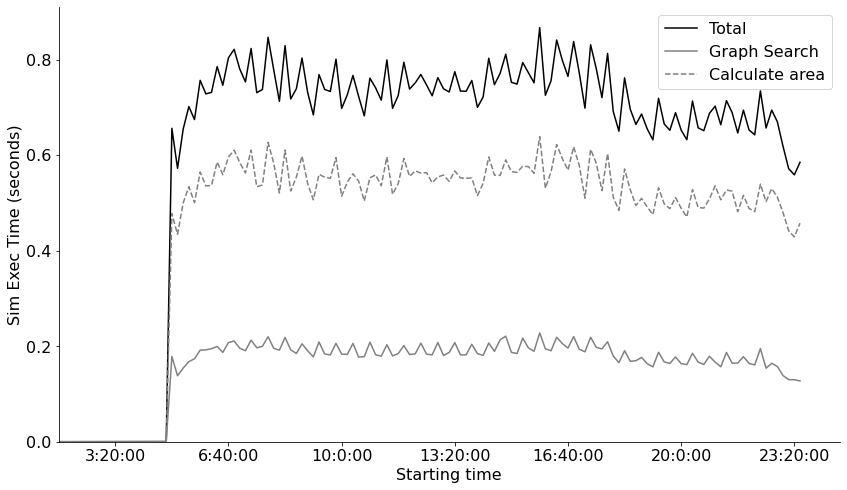

In [6]:
plt.rcParams["font.size"] = 16

fig, ax = plt.subplots(figsize=(14,8))
perf["total"].plot.line(ax=ax, label="Total", color="k", xlim=10, ylim=0)
perf["graph-search"].plot.line(ax=ax, label="Graph Search", color="0.5")
perf["calc-area"].plot.line(ax=ax, label="Calculate area", color="0.5", linestyle="--")
ax.set_xlabel("Starting time")
ax.set_ylabel("Sim Exec Time (seconds)")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend()

2162.0

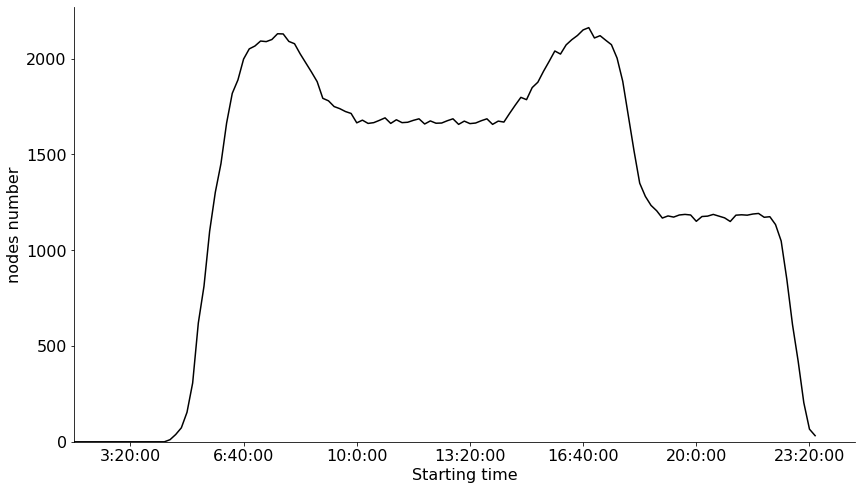

In [7]:
fig, ax = plt.subplots(figsize=(14,8))
perf["nodes-num"].plot.line(ax=ax, label="nodes number", color="k", xlim=10, ylim=0)
ax.set_xlabel("Starting time")
ax.set_ylabel("nodes number")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

perf["nodes-num"].max()

In [3]:
def gen_locations(num):
    mmt_gtfs_path = os.path.join(DATA_PATH, "mmt_gtfs")
    stops_df = pd.read_csv(os.path.join(
        mmt_gtfs_path, "stops.csv"), sep=",")
    locations = []

    lat_min = stops_df.stop_lat.min()
    lat_max = stops_df.stop_lat.max()
    lon_min = stops_df.stop_lon.min()
    lon_max = stops_df.stop_lon.max()

    for i in range(num):
        lat = random.random() * (lat_max - lat_min) + lat_min
        lon = random.random() * (lon_max - lon_min) + lon_min
        locations.append((lat, lon))

    return locations

In [4]:
t0 = time.time()
busSim = BusSim(DATA_PATH, DAY, "10:00:00", ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)
t1 = time.time()
for location in gen_locations(10):
    print("--------------------------------------------------------------")
    gdf = busSim.get_gdf(start_point=(location[0], location[1]))
    busSim.get_area(gdf)
t2 = time.time()

--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------


In [5]:
from busSim.util import get_perf
from datetime import datetime
import matplotlib

matplotlib.rcParams["font.size"] = 18

(array([0, 1, 2]),
 [Text(0, 0, 'graph_search'),
  Text(1, 0, 'projections'),
  Text(2, 0, 'uninioning')])

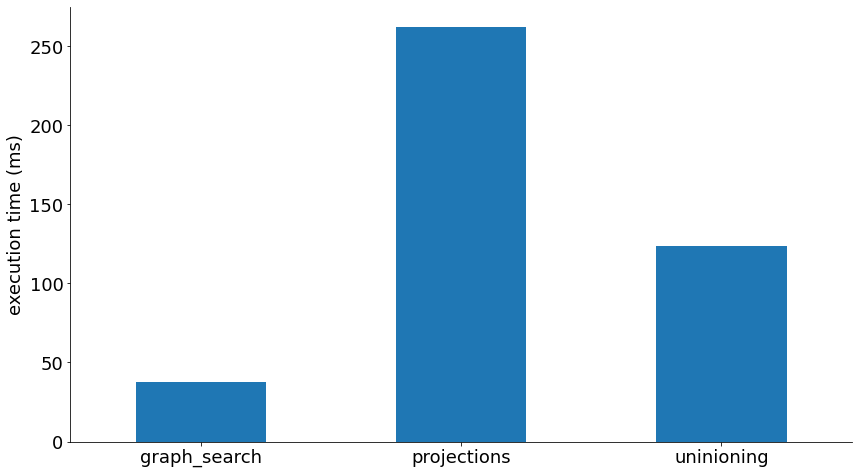

In [6]:
fig, ax = plt.subplots(figsize=(14,8))
perf_df = get_perf("busSim.log")
perf_df.mean().plot.bar(ax = ax)
ax.set_ylabel("execution time (ms)")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xticks(rotation=0)